# 이상 거래 분석 시스템

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Display settings
plt.style.use('ggplot')
sns.set(style='whitegrid')

## 2. Load and Explore Dataset

In [2]:
# Load the datasets
train_transaction = pd.read_csv('data/train_transaction.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [3]:
# Display the first few rows of each dataset
print("Train Transaction Data:")
print(train_transaction.head())

print("\nTest Transaction Data:")
print(test_transaction.head())

print("\nTrain Identity Data:")
print(train_identity.head())

print("\nTest Identity Data:")
print(test_identity.head())

Train Transaction Data:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   Na

In [4]:
# Display basic information about each dataset
print("Train Transaction Info:")
print(train_transaction.info())

print("\nTest Transaction Info:")
print(test_transaction.info())

print("\nTrain Identity Info:")
print(train_identity.info())

print("\nTest Identity Info:")
print(test_identity.info())

Train Transaction Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None

Test Transaction Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB
None

Train Identity Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-n

In [5]:
# Check for missing values in the datasets
missing_values_train_transaction = train_transaction.isnull().sum()
missing_values_train_identity = train_identity.isnull().sum()
print("Missing values in train_transaction:\n", missing_values_train_transaction[missing_values_train_transaction > 0])
print("Missing values in train_identity:\n", missing_values_train_identity[missing_values_train_identity > 0])

Missing values in train_transaction:
 card2      8933
card3      1565
card4      1577
card5      4259
card6      1571
          ...  
V335     508189
V336     508189
V337     508189
V338     508189
V339     508189
Length: 374, dtype: int64
Missing values in train_identity:
 id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37      

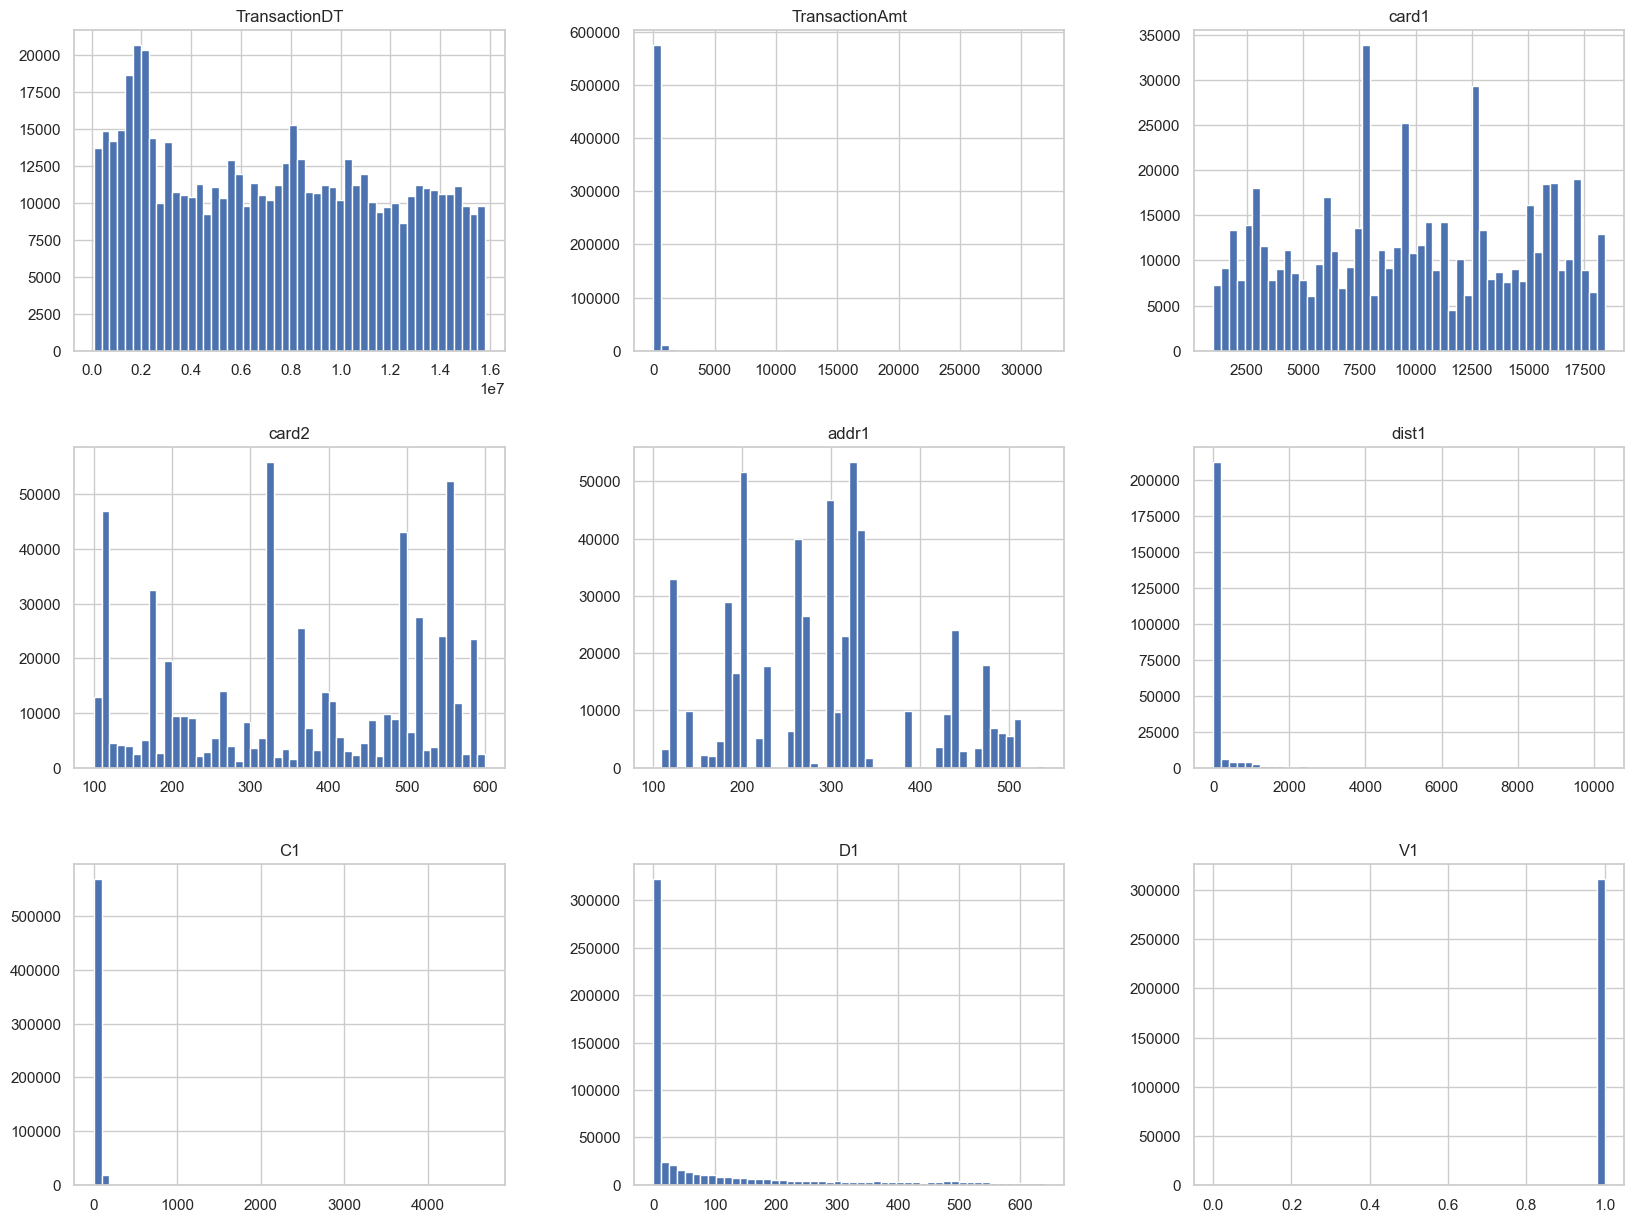

In [6]:
# Visualize the distribution of selected features in train_transaction
selected_features = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C1', 'D1', 'V1']
train_transaction[selected_features].hist(bins=50, figsize=(20, 15))
plt.show()

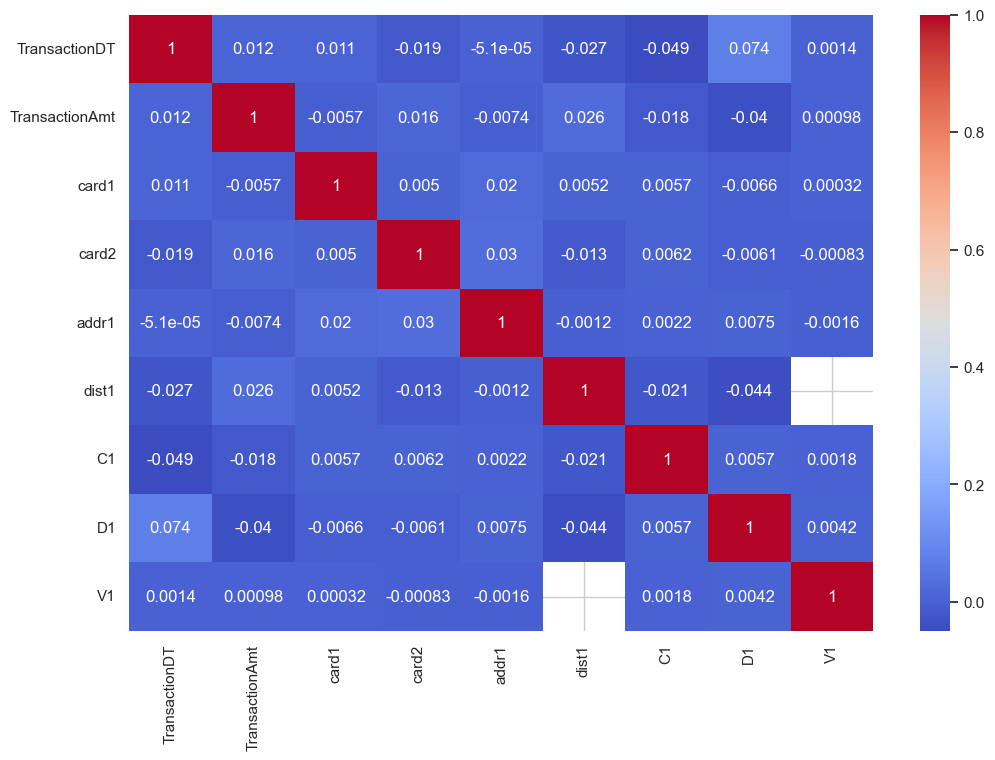

In [7]:
# Visualize the correlation matrix for selected features in train_transaction
selected_features = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C1', 'D1', 'V1']
correlation_matrix = train_transaction[selected_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 3. Data Preprocessing

In [8]:
# Merge train_transaction and train_identity on 'TransactionID'
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Merge test_transaction and test_identity on 'TransactionID'
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [9]:
# Sample the data to reduce memory usage (use 10% of the data)
train_data_sampled = train_data.sample(frac=0.1, random_state=42)

In [10]:
# Remove duplicate rows
train_data_sampled = train_data_sampled.drop_duplicates()
test_data = test_data.drop_duplicates()

# Check for duplicates
duplicate_rows_train = train_data_sampled.duplicated().sum()
duplicate_rows_test = test_data.duplicated().sum()
print(f"Number of duplicate rows in train data after removal: {duplicate_rows_train}")
print(f"Number of duplicate rows in test data after removal: {duplicate_rows_test}")

Number of duplicate rows in train data after removal: 0
Number of duplicate rows in test data after removal: 0


In [11]:
# Check for missing values in the merged dataset
missing_values_train_data = train_data_sampled.isnull().sum()
missing_values_test_data = test_data.isnull().sum()
print("Missing values in train_data:\n", missing_values_train_data[missing_values_train_data > 0])
print("Missing values in test_data:\n", missing_values_test_data[missing_values_test_data > 0])

Missing values in train_data:
 card2           904
card3           157
card4           159
card5           451
card6           158
              ...  
id_36         44980
id_37         44980
id_38         44980
DeviceType    44993
DeviceInfo    47261
Length: 382, dtype: int64
Missing values in test_data:
 card2           8654
card3           3002
card4           3086
card5           4547
card6           3007
               ...  
id-36         369714
id-37         369714
id-38         369714
DeviceType    369760
DeviceInfo    391634
Length: 385, dtype: int64


In [12]:
# Align specific column names between train and test data
rename_columns = {f'id-{i:02d}': f'id_{i:02d}' for i in range(1, 39)}
test_data = test_data.rename(columns=rename_columns)

# Find columns in train but not in test
train_only_cols = train_data_sampled.columns.difference(test_data.columns)

# Print columns in train but not in test
print("Columns in train data but not in test data:", train_only_cols)

Columns in train data but not in test data: Index(['isFraud'], dtype='object')


In [13]:
# Separate numerical and categorical features
numerical_features = train_data_sampled.select_dtypes(include=[np.number]).columns
categorical_features = train_data_sampled.select_dtypes(include=[object]).columns

# Handle missing values by filling them with the median of each column for numerical features
train_data_sampled[numerical_features] = train_data_sampled[numerical_features].fillna(train_data_sampled[numerical_features].median())
test_data[numerical_features.intersection(test_data.columns)] = test_data[numerical_features.intersection(test_data.columns)].fillna(test_data[numerical_features.intersection(test_data.columns)].median())

# Convert numerical features to float32 to reduce memory usage
train_data_sampled[numerical_features] = train_data_sampled[numerical_features].astype(np.float32)
test_data[numerical_features.intersection(test_data.columns)] = test_data[numerical_features.intersection(test_data.columns)].astype(np.float32)

# Handle missing values by filling them with the most frequent value for categorical features
train_data_sampled[categorical_features] = train_data_sampled[categorical_features].fillna(train_data_sampled[categorical_features].mode().iloc[0])
test_data[categorical_features.intersection(test_data.columns)] = test_data[categorical_features.intersection(test_data.columns)].fillna(test_data[categorical_features.intersection(test_data.columns)].mode().iloc[0])

In [14]:
# Separate the 'isFraud' column
is_Fraud = train_data_sampled['isFraud']

# One-Hot Encoding
train_data_sampled = pd.get_dummies(train_data_sampled.drop(columns=['isFraud']))
test_data = pd.get_dummies(test_data)

# Use only the common columns excluding 'isFraud'
common_columns = train_data_sampled.columns.intersection(test_data.columns)

# Align the columns of train and test data to have the same order
train_data_sampled = train_data_sampled[common_columns]
test_data = test_data[common_columns]

# Add the 'isFraud' column back to the training dataset
train_data_sampled['isFraud'] = is_Fraud

In [15]:
# Display the first few rows of the preprocessed dataset
train_data_sampled.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,DeviceInfo_rv:53.0,DeviceInfo_rv:54.0,DeviceInfo_rv:55.0,DeviceInfo_rv:56.0,DeviceInfo_rv:57.0,DeviceInfo_rv:58.0,DeviceInfo_rv:59.0,DeviceInfo_rv:60.0,DeviceInfo_rv:61.0,isFraud
470624,3457624.0,12153579.0,724.000000,7826.0,481.0,150.0,224.0,387.0,87.0,8.0,...,False,False,False,False,False,False,False,False,False,0.0
565820,3552820.0,15005886.0,108.500000,12544.0,321.0,150.0,226.0,476.0,87.0,0.0,...,False,False,False,False,False,False,False,False,False,0.0
284083,3271083.0,6970178.0,47.950001,9400.0,111.0,150.0,224.0,315.0,87.0,6.0,...,False,False,False,False,False,False,False,False,False,0.0
239689,3226689.0,5673658.0,100.598999,15885.0,545.0,185.0,138.0,299.0,87.0,8.0,...,False,False,False,False,False,False,False,False,False,0.0
281855,3268855.0,6886780.0,107.949997,15497.0,490.0,150.0,226.0,299.0,87.0,8.0,...,False,False,False,False,False,False,False,False,False,0.0


In [16]:
# Display basic information about the preprocessed dataset
train_data_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59054 entries, 470624 to 579244
Columns: 1471 entries, TransactionID to isFraud
dtypes: bool(1068), float32(403)
memory usage: 151.4 MB


In [17]:
# Display summary statistics of the preprocessed dataset
train_data_sampled.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,isFraud
count,5.905400e+04,59054.00,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,...,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000
mean,3.281903e+06,7361626.00,135.235519,9895.574219,362.379791,153.193207,199.299759,291.136017,86.820686,50.807415,...,14.939564,343.999969,453.432983,252.988190,14.014750,11.013767,321.070709,158.920868,24.327158,0.035713
std,1.701324e+05,4606494.00,265.428741,4912.184570,156.690598,11.383129,41.331894,95.861137,2.508159,233.447449,...,0.474598,68.736794,79.095207,20.996416,0.617594,0.257047,9.084846,2.988084,1.595971,0.185575
min,2.987002e+06,86469.00,0.350000,1007.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,11.000000,100.000000,100.000000,123.000000,14.000000,11.000000,100.000000,100.000000,0.000000,0.000000
25%,3.135063e+06,3033211.25,43.290751,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,8.000000,...,15.000000,341.000000,469.000000,252.000000,14.000000,11.000000,321.000000,159.000000,24.000000,0.000000
50%,3.281857e+06,7273272.00,68.500000,9653.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,15.000000,341.000000,469.000000,252.000000,14.000000,11.000000,321.000000,159.000000,24.000000,0.000000
75%,3.428169e+06,11207394.25,125.000000,14259.000000,512.000000,150.000000,226.000000,327.000000,87.000000,8.000000,...,15.000000,341.000000,469.000000,252.000000,14.000000,11.000000,321.000000,159.000000,24.000000,0.000000
max,3.577512e+06,15810563.00,31937.390625,18393.000000,600.000000,231.000000,237.000000,536.000000,102.000000,6466.000000,...,28.000000,671.000000,660.000000,854.000000,41.000000,26.000000,548.000000,216.000000,32.000000,1.000000


## 4. Split the Dataset

In [18]:
# Separate features and target variable from the merged dataset
X = train_data_sampled.drop('isFraud', axis=1)
y = train_data_sampled['isFraud']

In [19]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (47243, 1470)
Validation set size: (11811, 1470)


## 5. Exploratory Data Analysis (EDA)

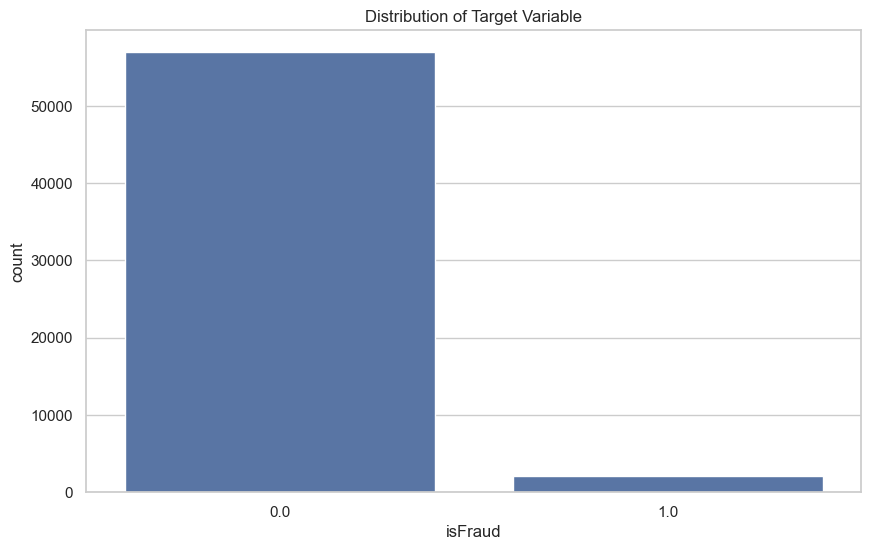

In [20]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='isFraud', data=train_data_sampled)
plt.title('Distribution of Target Variable')
plt.show()

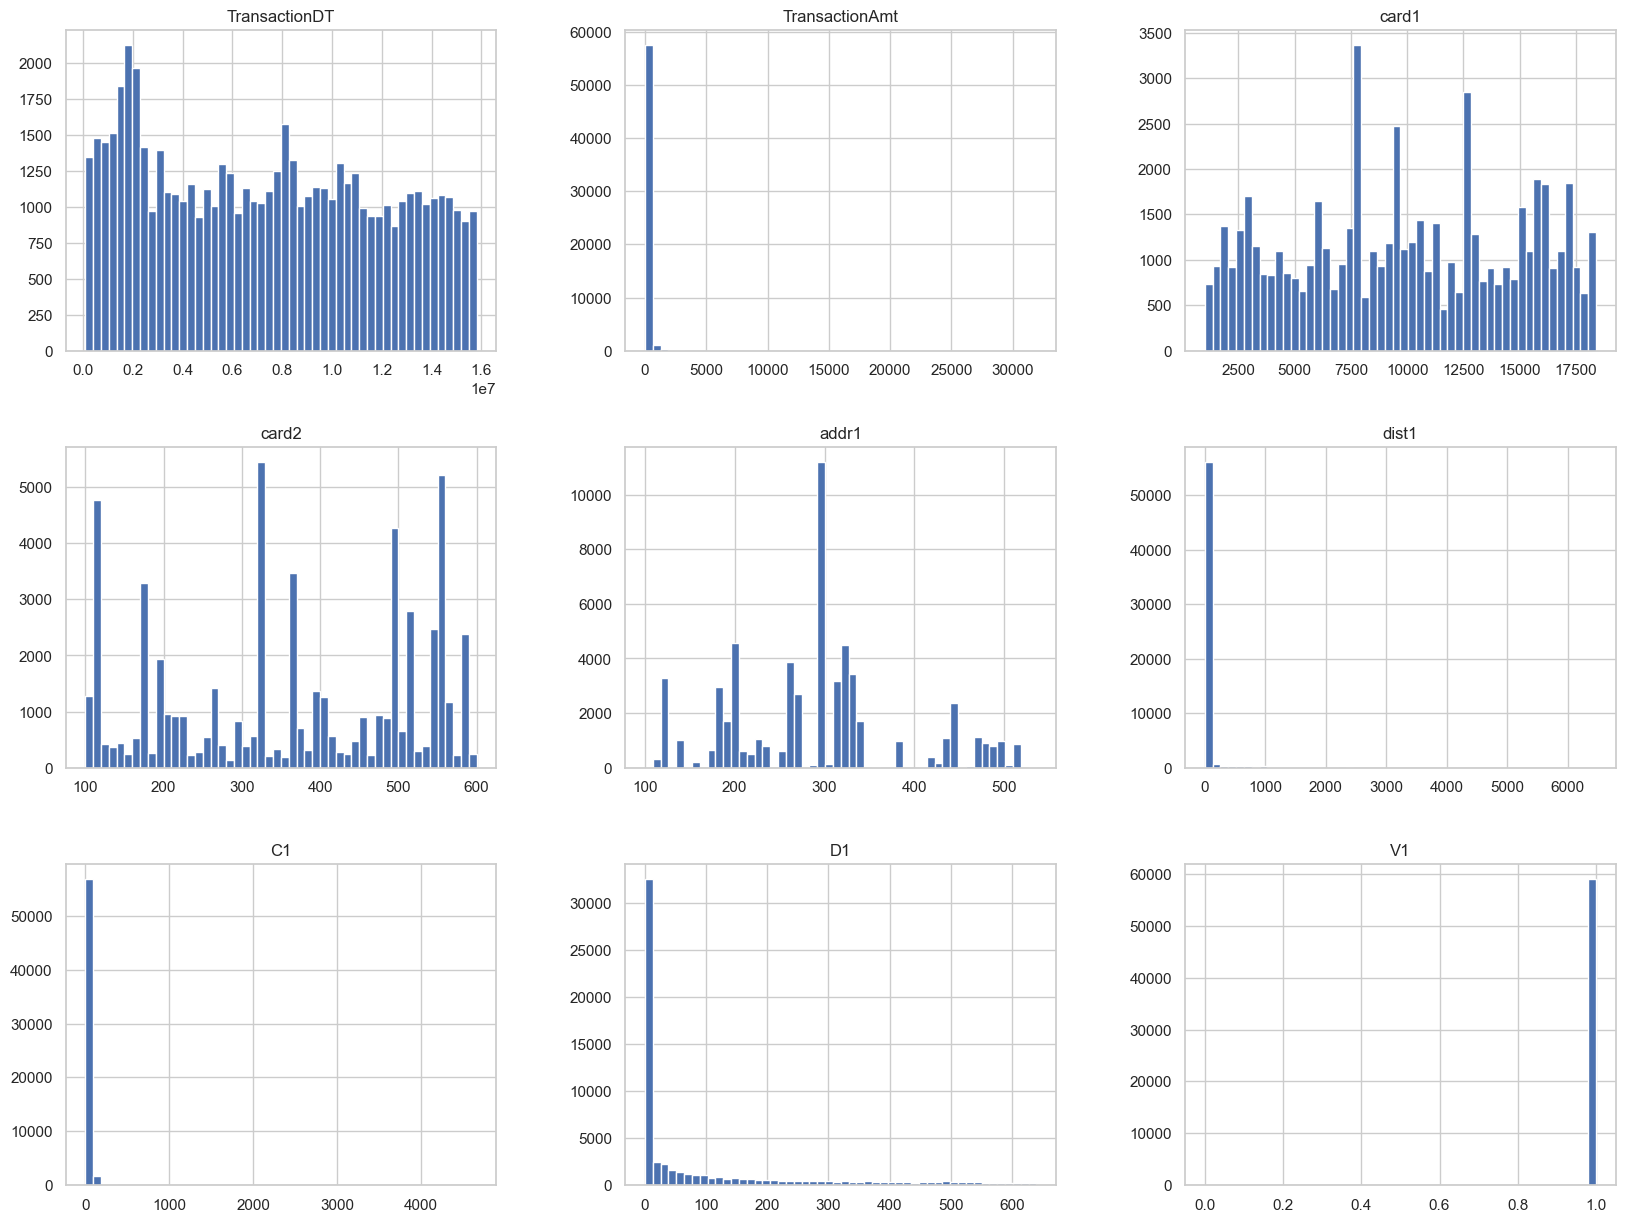

In [21]:
# Visualize the distribution of numerical features
numerical_features = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C1', 'D1', 'V1']
train_data_sampled[numerical_features].hist(bins=50, figsize=(20, 15))
plt.show()

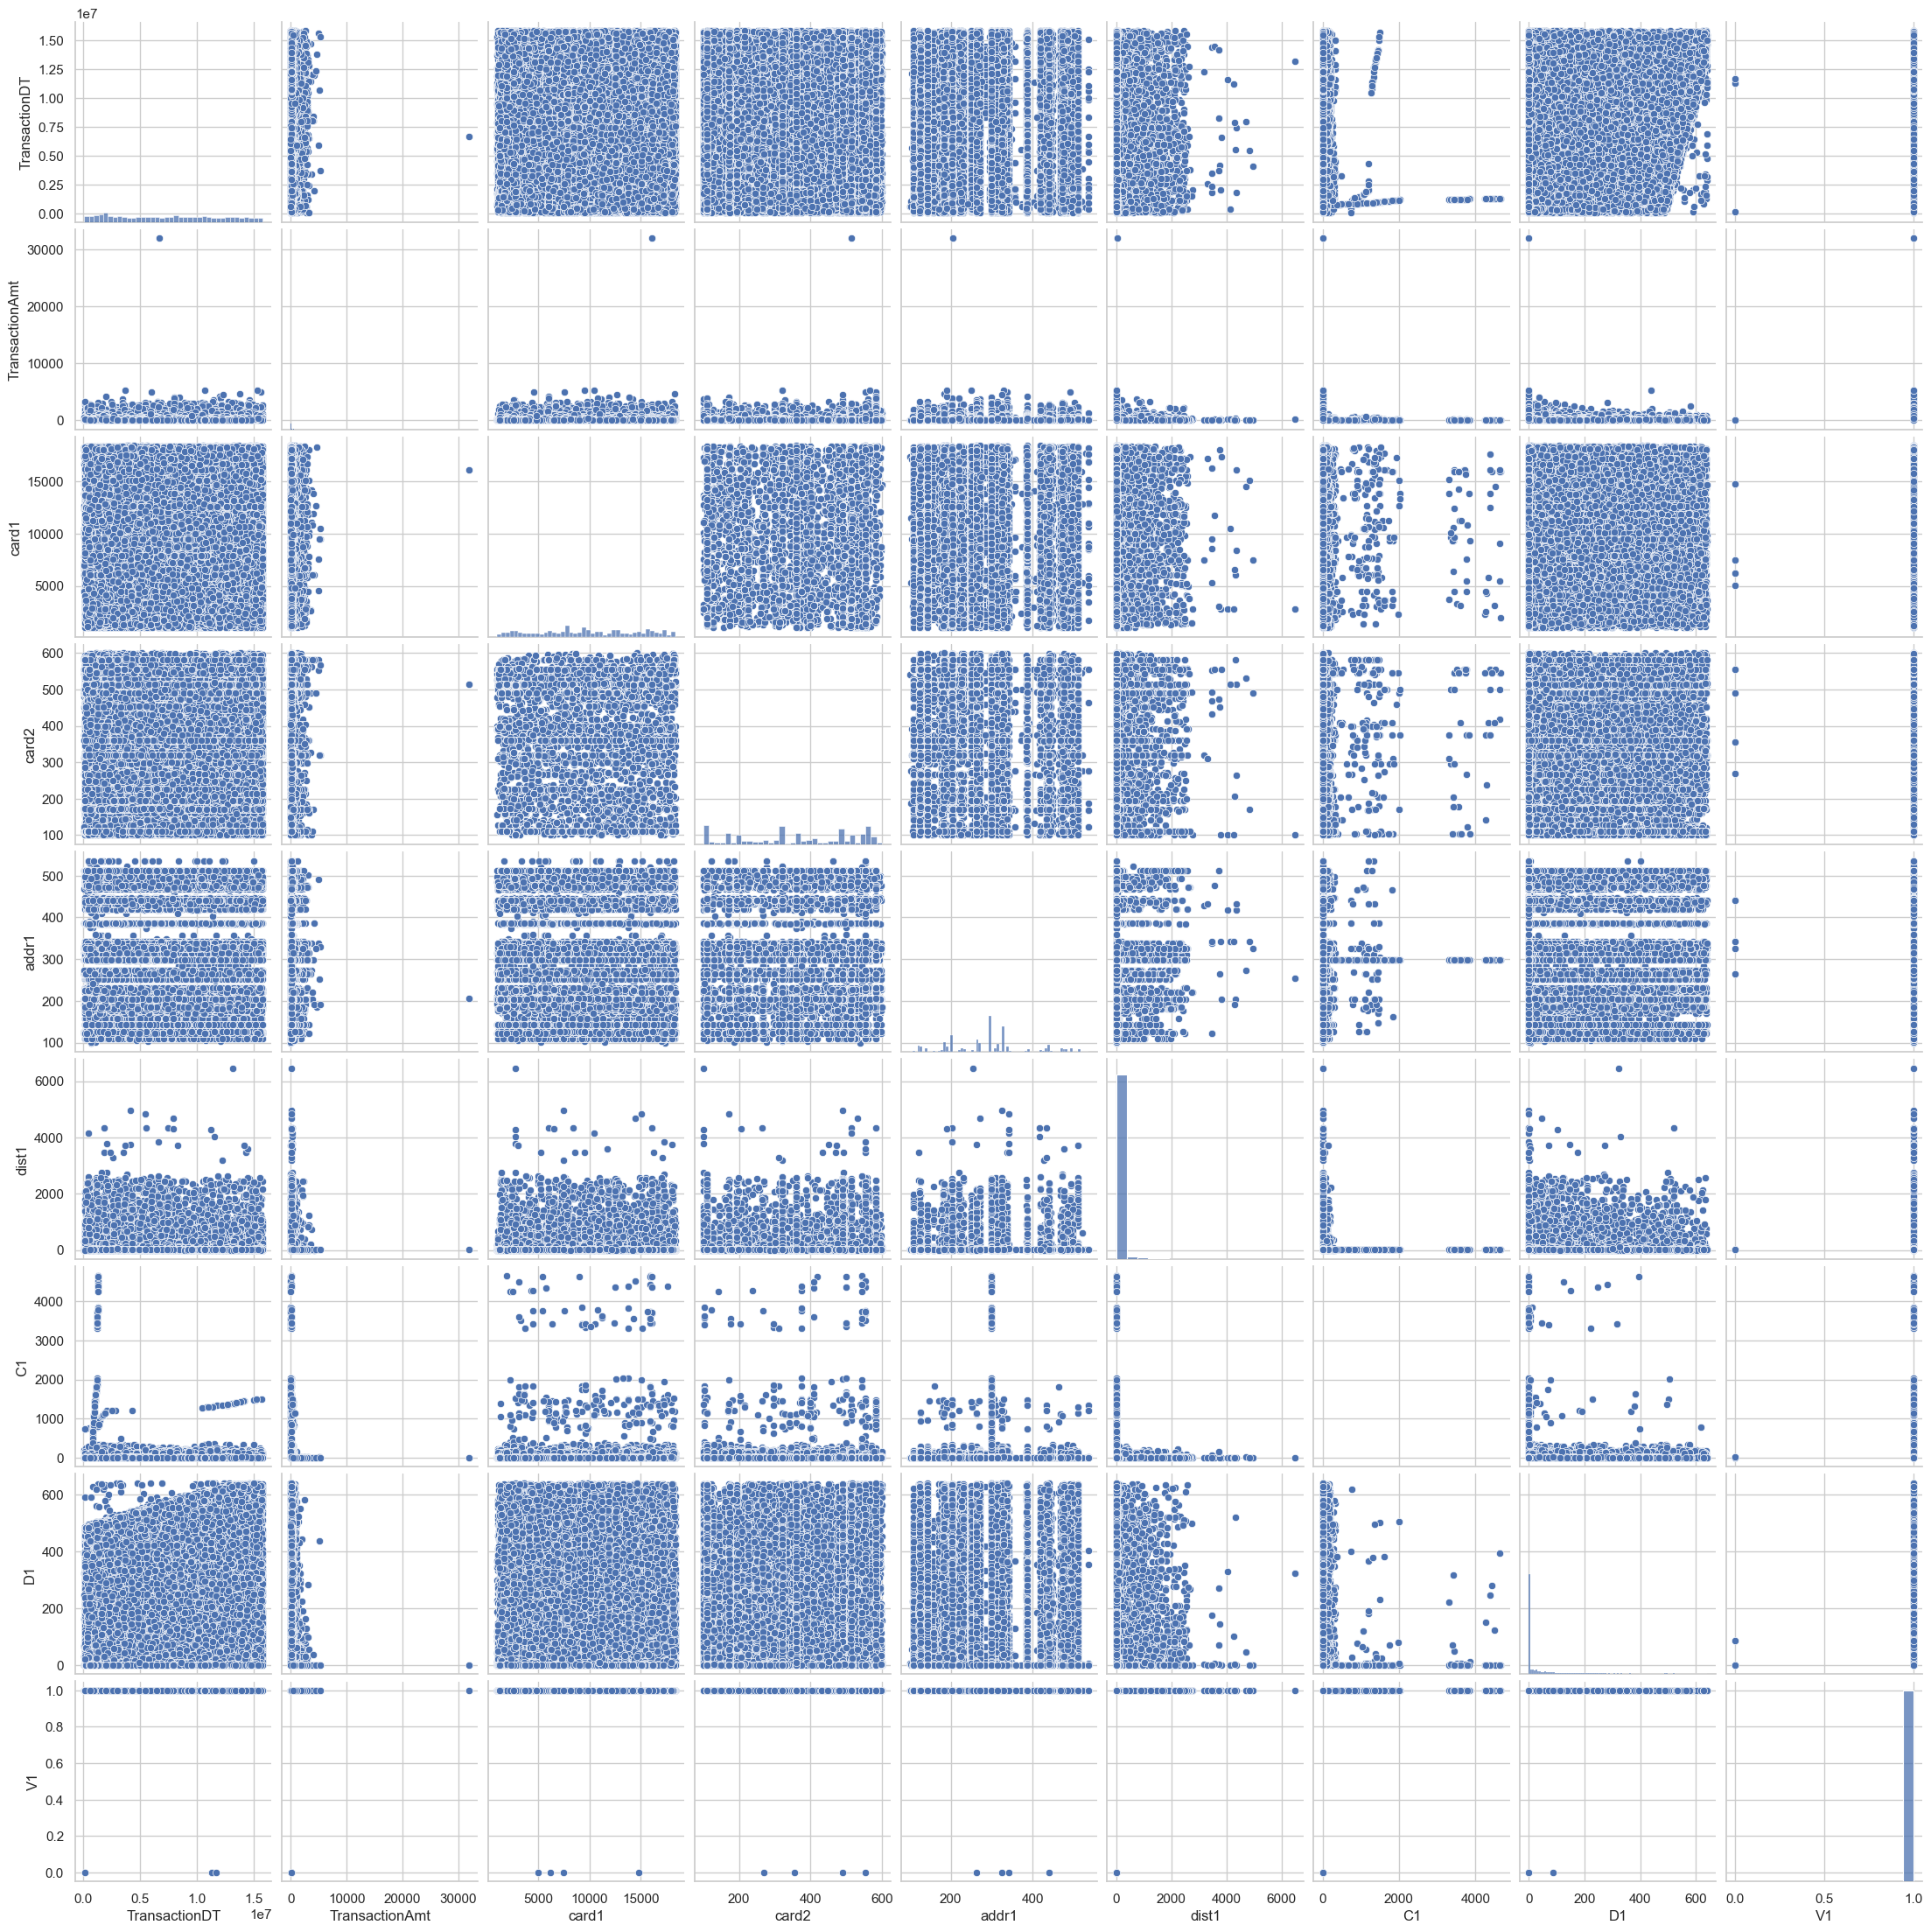

In [22]:
# Visualize pairplot to identify relationships between features
sns.pairplot(train_data_sampled[numerical_features])
plt.show()

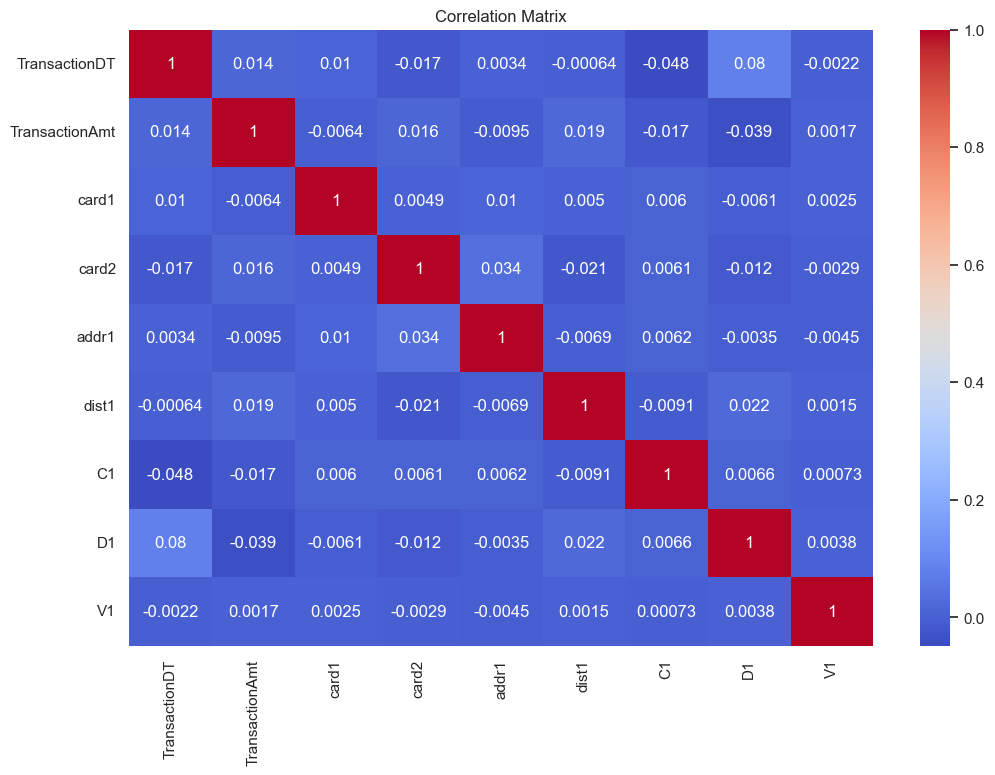

In [23]:
# Visualize the correlation matrix
correlation_matrix = train_data_sampled[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

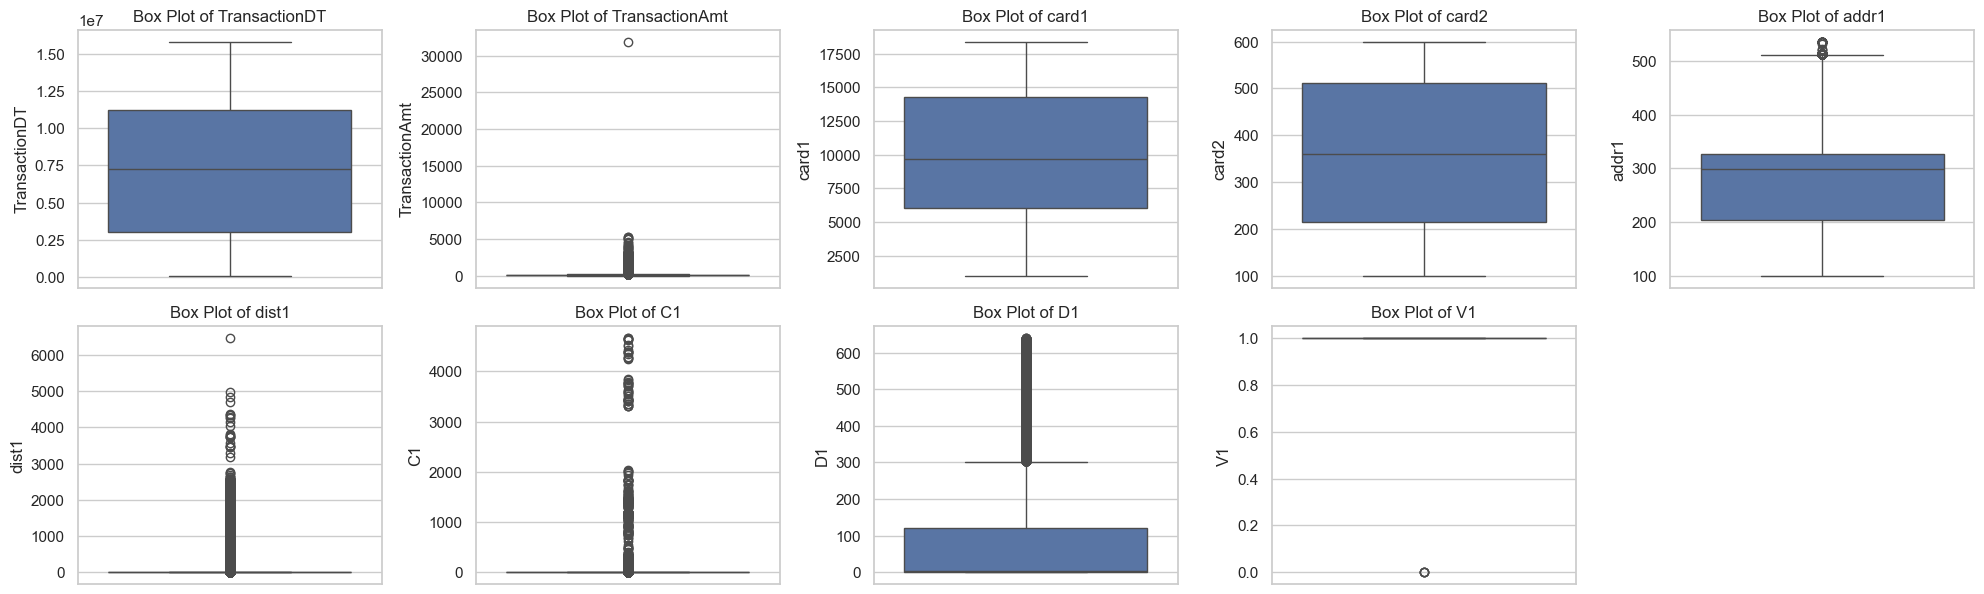

In [24]:
# Identify outliers using box plots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(train_data_sampled[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [25]:
# Display summary statistics of the numerical features
train_data_sampled[numerical_features].describe()

,TransactionDT,TransactionAmt,card1,card2,addr1,dist1,C1,D1,V1
count,59054.00,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000
mean,7361626.00,135.235519,9895.574219,362.379791,291.136017,50.807415,14.111321,93.718681,0.999932
std,4606494.00,265.428741,4912.184570,156.690598,95.861137,233.447449,133.153809,157.267975,0.008230
min,86469.00,0.350000,1007.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000
25%,3033211.25,43.290751,6019.000000,215.000000,204.000000,8.000000,1.000000,0.000000,1.000000
50%,7273272.00,68.500000,9653.000000,361.000000,299.000000,8.000000,1.000000,3.000000,1.000000
75%,11207394.25,125.000000,14259.000000,512.000000,327.000000,8.000000,3.000000,121.000000,1.000000
max,15810563.00,31937.390625,18393.000000,600.000000,536.000000,6466.000000,4665.000000,640.000000,1.000000


## 6. Feature Selection and Dimensionality Reduction

In [26]:
from catboost import CatBoostClassifier

# Train a CatBoost model to get feature importances
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Get feature importances
importances = catboost_model.get_feature_importance()
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display feature importances
print(feature_importances)

# Select top N important features (top 100 features)
top_n_features = feature_importances.head(100)['feature']
X_train_top_n = X_train[top_n_features]
X_val_top_n = X_val[top_n_features]
X_test_top_n = test_data[top_n_features]

                 feature  importance
24                   C14    3.841187
2         TransactionAmt    3.545289
3                  card1    3.443444
11                    C1    3.114761
0          TransactionID    2.960609
...                  ...         ...
810      id_33_3441x1440    0.000000
811      id_33_3840x1080    0.000000
812      id_33_3840x1600    0.000000
813      id_33_3840x2160    0.000000
1469  DeviceInfo_rv:61.0    0.000000

[1470 rows x 2 columns]


In [27]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of features
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_top_n)
X_val_pca = pca.transform(X_val_top_n)
X_test_pca = pca.transform(X_test_top_n)

# Display explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)
print("Number of components selected:", pca.n_components_)
print("Total explained variance:", explained_variance_ratio.sum())

Explained variance ratio: [9.99674439e-01 3.14602570e-04 4.78811444e-06 4.37907102e-06
 1.12840678e-06 4.54531516e-07 1.41999777e-07 7.02455196e-08
 3.78382623e-08 1.67547700e-08 7.57237473e-09 5.67370417e-09
 4.80690021e-09 4.55151872e-09 3.22039861e-09 2.54417976e-09
 2.43544762e-09 1.55887669e-09 1.14780574e-09 9.54542223e-10
 8.99658403e-10 8.07319767e-10 6.47694176e-10 5.44363055e-10
 4.32215708e-10 3.95284444e-10 3.73882730e-10 3.64969804e-10
 3.53019974e-10 2.75668710e-10 2.66168976e-10 2.05622727e-10
 1.91509253e-10 1.67026698e-10 1.13307155e-10 9.00622354e-11
 7.99261490e-11 7.68197936e-11 6.47408932e-11 4.57728751e-11
 2.68342848e-11 2.22851824e-11 1.24771938e-11 8.90591767e-12
 4.43045947e-12 3.06579675e-12 2.21050695e-12 1.71586053e-12
 1.55460714e-12 1.24768316e-12]
Number of components selected: 50
Total explained variance: 1.0000001


## 7. Model Training

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42, scale_pos_weight=len(y_train) / sum(y_train)),
    "LightGBM": LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42, class_weight='balanced'),
    "CatBoost": CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, class_weights=[1, len(y_train) / sum(y_train)], verbose=0)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    print(f"{name} Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred))

c:\Users\rose0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Confusion Matrix:
[[4287 7077]
 [  55  392]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.38      0.55     11364
         1.0       0.05      0.88      0.10       447

    accuracy                           0.40     11811
   macro avg       0.52      0.63      0.32     11811
weighted avg       0.95      0.40      0.53     11811

Random Forest Confusion Matrix:
[[11359     5]
 [  400    47]]

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     11364
         1.0       0.90      0.11      0.19       447

    accuracy                           0.97     11811
   macro avg       0.93      0.55      0.59     11811
weighted avg       0.96      0.97      0.95     11811

XGBoost Confusion Matrix:
[[11325    39]
 [  306   141]]

XGBoost Classification Report:
              precision    recall  f1-score   s

In [29]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train)

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for each model with reduced ranges
param_grid_xgb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

param_grid_lgbm = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50]
}

param_grid_catboost = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6]
}

# Perform RandomizedSearchCV for each model with limited parallel processing
xgb_random = RandomizedSearchCV(XGBClassifier(random_state=42), param_distributions=param_grid_xgb, n_iter=10, cv=3, random_state=42, n_jobs=2)
lgbm_random = RandomizedSearchCV(LGBMClassifier(random_state=42), param_distributions=param_grid_lgbm, n_iter=10, cv=3, random_state=42, n_jobs=2)
catboost_random = RandomizedSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_distributions=param_grid_catboost, n_iter=10, cv=3, random_state=42, n_jobs=2)

# Fit the models
xgb_random.fit(X_resampled, y_resampled)
lgbm_random.fit(X_resampled, y_resampled)
catboost_random.fit(X_resampled, y_resampled)

# Get the best models
best_xgb = xgb_random.best_estimator_
best_lgbm = lgbm_random.best_estimator_
best_catboost = catboost_random.best_estimator_

c:\Users\rose0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\rose0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 45581, number of negative: 45581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 91162, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\rose0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [31]:
from sklearn.ensemble import StackingClassifier

# Define base models for Stacking Classifier
base_models = [
    ('xgb', best_xgb),
    ('lgbm', best_lgbm),
    ('catboost', best_catboost)
]

# Define meta model
meta_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Create Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)
stacking_clf.fit(X_resampled, y_resampled)

# Evaluate Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_val_pca)
print("Stacking Classifier Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_stacking))
print("\nStacking Classifier Classification Report:")
print(classification_report(y_val, y_pred_stacking))

[LightGBM] [Info] Number of positive: 45581, number of negative: 45581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 91162, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 30387, number of negative: 30387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60774, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 30388, number of n

In [32]:
from sklearn.ensemble import VotingClassifier

# Define base models for Voting Classifier
base_models = [
    ('xgb', best_xgb),
    ('lgbm', best_lgbm),
    ('catboost', best_catboost)
]

# Create Voting Classifier
voting_clf = VotingClassifier(estimators=base_models, voting='soft')
voting_clf.fit(X_resampled, y_resampled)

# Evaluate Voting Classifier
y_pred_voting = voting_clf.predict(X_val_pca)
print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_voting))
print("\nVoting Classifier Classification Report:")
print(classification_report(y_val, y_pred_voting))

[LightGBM] [Info] Number of positive: 45581, number of negative: 45581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 91162, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Voting Classifier Confusion Matrix:
[[11151   213]
 [  253   194]]

Voting Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11364
         1.0       0.48      0.43      0.45       447

    accuracy                           0.96     11811
   macro avg       0.73      0.71      0.72     11811
weighted avg       0.96      0.96      0.96     11811



In [33]:
# Define a function to adjust the threshold
def adjust_threshold(model, X_val, threshold=0.5):
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred

# Adjust threshold and evaluate Stacking Classifier
threshold = 0.3  # Adjust this value to find the optimal threshold
y_pred_stacking_adjusted = adjust_threshold(stacking_clf, X_val_pca, threshold)
print("Stacking Classifier Confusion Matrix with adjusted threshold:")
print(confusion_matrix(y_val, y_pred_stacking_adjusted))
print("\nStacking Classifier Classification Report with adjusted threshold:")
print(classification_report(y_val, y_pred_stacking_adjusted))

# Adjust threshold and evaluate Voting Classifier
y_pred_voting_adjusted = adjust_threshold(voting_clf, X_val_pca, threshold)
print("Voting Classifier Confusion Matrix with adjusted threshold:")
print(confusion_matrix(y_val, y_pred_voting_adjusted))
print("\nVoting Classifier Classification Report with adjusted threshold:")
print(classification_report(y_val, y_pred_voting_adjusted))

Stacking Classifier Confusion Matrix with adjusted threshold:
[[11172   192]
 [  256   191]]

Stacking Classifier Classification Report with adjusted threshold:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11364
         1.0       0.50      0.43      0.46       447

    accuracy                           0.96     11811
   macro avg       0.74      0.71      0.72     11811
weighted avg       0.96      0.96      0.96     11811

Voting Classifier Confusion Matrix with adjusted threshold:
[[10826   538]
 [  214   233]]

Voting Classifier Classification Report with adjusted threshold:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     11364
         1.0       0.30      0.52      0.38       447

    accuracy                           0.94     11811
   macro avg       0.64      0.74      0.67     11811
weighted avg       0.95      0.94      0.94     11811



In [34]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Define a function to find the optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    
    # Calculate F1-scores
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Handle NaN values in f1_scores
    f1_scores = np.nan_to_num(f1_scores)  # Replace NaN with 0
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Find the optimal threshold for Stacking Classifier
optimal_threshold_stacking = find_optimal_threshold(stacking_clf, X_val_pca, y_val)
y_pred_stacking_optimal = adjust_threshold(stacking_clf, X_val_pca, optimal_threshold_stacking)

# Display results for Stacking Classifier
print("Stacking Classifier Confusion Matrix with optimal threshold:")
print(confusion_matrix(y_val, y_pred_stacking_optimal))
print("\nStacking Classifier Classification Report with optimal threshold:")
print(classification_report(y_val, y_pred_stacking_optimal))

# Find the optimal threshold for Voting Classifier
optimal_threshold_voting = find_optimal_threshold(voting_clf, X_val_pca, y_val)
y_pred_voting_optimal = adjust_threshold(voting_clf, X_val_pca, optimal_threshold_voting)

# Display results for Voting Classifier
print("Voting Classifier Confusion Matrix with optimal threshold:")
print(confusion_matrix(y_val, y_pred_voting_optimal))
print("\nVoting Classifier Classification Report with optimal threshold:")
print(classification_report(y_val, y_pred_voting_optimal))

Stacking Classifier Confusion Matrix with optimal threshold:
[[11226   138]
 [  266   181]]

Stacking Classifier Classification Report with optimal threshold:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     11364
         1.0       0.57      0.40      0.47       447

    accuracy                           0.97     11811
   macro avg       0.77      0.70      0.73     11811
weighted avg       0.96      0.97      0.96     11811

Voting Classifier Confusion Matrix with optimal threshold:
[[11225   139]
 [  266   181]]

Voting Classifier Classification Report with optimal threshold:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     11364
         1.0       0.57      0.40      0.47       447

    accuracy                           0.97     11811
   macro avg       0.77      0.70      0.73     11811
weighted avg       0.96      0.97      0.96     11811



## 8. Model Evaluation

In [35]:
# Voting Classifier with optimal threshold
y_proba_voting = voting_clf.predict_proba(X_val_pca)[:, 1]
y_pred_voting_optimal = adjust_threshold(voting_clf, X_val_pca, optimal_threshold_voting)

# Display results for Voting Classifier
print("Voting Classifier Confusion Matrix with optimal threshold:")
print(confusion_matrix(y_val, y_pred_voting_optimal))
print("\nVoting Classifier Classification Report with optimal threshold:")
print(classification_report(y_val, y_pred_voting_optimal))

Voting Classifier Confusion Matrix with optimal threshold:
[[11225   139]
 [  266   181]]

Voting Classifier Classification Report with optimal threshold:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     11364
         1.0       0.57      0.40      0.47       447

    accuracy                           0.97     11811
   macro avg       0.77      0.70      0.73     11811
weighted avg       0.96      0.97      0.96     11811



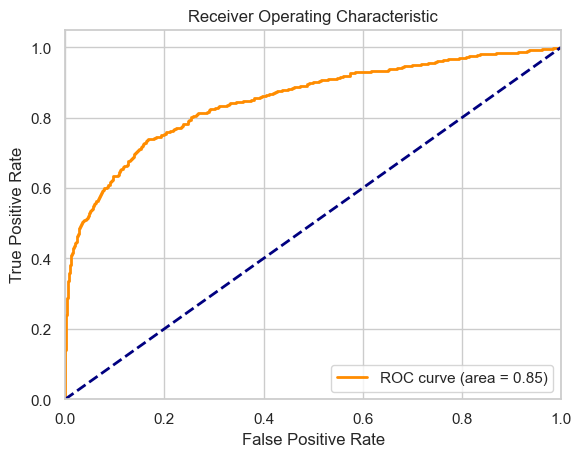

In [36]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba_voting)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

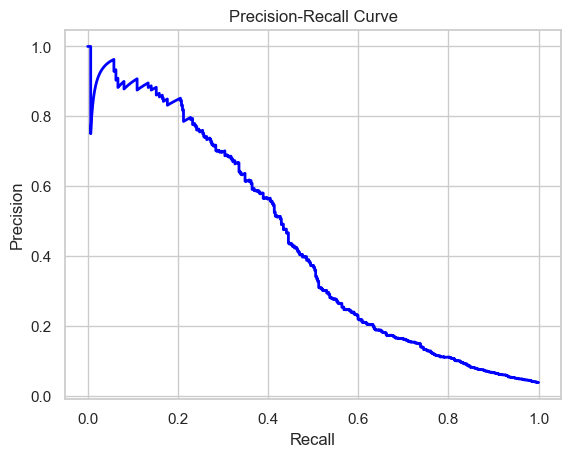

In [37]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba_voting)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## 9. Model Testing

In [43]:
# Select the final model as the Voting Classifier
final_model = voting_clf

# Make predictions on the test dataset using the optimal threshold
y_proba_test = final_model.predict_proba(X_test_pca)[:, 1]
y_pred_test = adjust_threshold(final_model, X_test_pca, optimal_threshold_voting)

# Create a DataFrame with the required format
submission = pd.DataFrame({
    'TransactionID': test_data['TransactionID'],
    'isFraud': y_pred_test
})

# Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)